# Retrieving Pseudo-MPC Observations for JUICE

## Objectives
In this example show how to retrieve pseudo-MPC data from Bill Gray's website. We will use the Tudat Horizons interface to compare observation ouput and load the standard SPICE kernels.

## Key API References

## Import statements

In [36]:
from tudatpy.data.mpc import BatchMPC
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.data.horizons import HorizonsQuery


from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation


# Load spice kernels
spice.load_standard_kernels()

## Workflow
Unlike what already done in the example [Retrieving_mpc_observation_data (ADD LINK)](), we cannout initialize the BatchMPC object yet, since astroquery...is not linked to Bill Gray's html page. We therefore need to 

1) parse B.G.'s html page containing the data, and retrieve the information needed (obs. time, angular observables, station codes, obs. band, etc...).
2) feed this information into a table that is similar to the one created (in the other example) using the `.get_observations()` method.
3) convert the newly created table into a `Batch.MPC` object using `.from_astropy()` .

### 1) Parsing the html page

In [37]:
from astroquery.mpc import MPC
import requests
import re
from tudatpy import constants

from astropy.time import Time
from astropy.table import Table, Column
from bs4 import BeautifulSoup
import pandas as pd

MPC.query_object = requests.get("https://www.projectpluto.com/pluto/mpecs/23053a.htm", "-28")

observations = MPC.query_object.text #use this if you want the whole html page
# Find the position of the <a name="stations"></a> tag
match = re.search(r'<a name="stations"></a>', observations)
if match:
    # Keep only the part of the HTML before the matched line
    html_cleaned = observations[:match.start()]
    #print(html_cleaned)
match = re.search(r'<a href="https://www.projectpluto.com/mpec_xpl.htm#astrometry"> <b>Astrometry:</b> </a>', html_cleaned)
if match:
    # Keep only the part of the HTML before the matched line
    html_cleaned = html_cleaned[match.end():].lstrip()
observations = [line.strip() for line in html_cleaned.splitlines() if line.strip()]

# Initialize lists to hold the extracted data
numbers = []
epochs = []
RAs = []
DECs = []
bands = []
observatories = []

for i,observation_string in enumerate(observations):
    soup = BeautifulSoup(observation_string, 'html.parser')

    number = i+1
    #print(f'observation n. {number}')

    # Extract the observation string (without the band and observatory)
    observation_string = soup.get_text().split(soup.find_all('a')[1].get_text())[1].split(soup.find_all('a')[2].get_text())[0].strip()
    print(observation_string)
    if observation_string[2] == 'K' or observation_string[1] == 'B':
        #print('no can do')
        continue
        
    # Extract and parse date and time
    if observation_string[0:2] == 'KC' or observation_string[0:2] == '0C' or observation_string[0:2] == '3C':
        year = observation_string[2:6]  # Year (e.g., 2023)
        month = observation_string[7:9]  # Month (e.g., 04)
        #print(month)
        date_part, frac_day = observation_string[10:19].split('.')
        #print(f'Day:{date_part}, Fraction of Day:{frac_day}')
        numbers.append(number)
    elif observation_string[0] == 'C':
        year = observation_string[1:5]  # Year (e.g., 2023)
        month = observation_string[6:8]  # Month (e.g., 04)
        #print(month)
        date_part, frac_day = observation_string[9:18].split('.')
        #print(f'Day:{date_part}, Fraction of Day:{frac_day}')
        numbers.append(number)

    # Calculate the time in hours, minutes, seconds
    hours = float("0." + frac_day) * 24
    minutes = (hours % 1) * 60
    seconds = (minutes % 1) * 60
    #print(f'Hours:{hours}, Minutes:{minutes}, Seconds:{seconds}')
    # Convert to Julian date
    time_string = f"{date_part} {int(hours):02}:{int(minutes):02}:{round(seconds):02}"
    epoch = f'{year}-{month}-{date_part} {int(hours):02}:{int(minutes):02}:{round(seconds):02}'
    #print(f'Epoch:{epoch}')
    dt = datetime.strptime(epoch, "%Y-%m-%d %H:%M:%S")
    dt_jd = Time(dt).jd
    epochs.append(dt_jd)

    # Extract RA and DEC
    if observation_string[0:2] == 'KC' or observation_string[0:2] == '0C' or observation_string[0:2] == '3C':
        ra_dec_str = observation_string[19:45]  # RA and DEC part
        #print(f'ra & dec str:{ra_dec_str}')
        ra_part = ra_dec_str[:12].strip()  # Right Ascension
        #print(f'ra part: {ra_part}')
        dec_part = ra_dec_str[12:].strip()  # Declination (considering no space if negative)
        #print(f'dec part:{dec_part}')

        #Right Ascension
        parts_RA = ra_part.split()
        hours_RA = float(parts_RA[0])
        minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
        seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
        deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240

        #Declination
        parts_DEC = dec_part.split()
        degrees_DEC = float(parts_DEC[0])
        minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
        seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
        if len(parts_DEC[0]) == 3:
            deg_dec = - (abs(degrees_DEC) + minutes_DEC / 60 + seconds_DEC / 3600)
        else:
            deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
        #print(f'deg_ra {deg_ra}')
        #print(f'deg_dec {deg_dec}')
        # Extract Band
        band = observation_string[57:58]

        bands.append(band)

    elif observation_string[0] == 'C':
        ra_dec_str = observation_string[18:45]  # RA and DEC part
        #print(f'ra & dec str:{ra_dec_str}')
        ra_part = ra_dec_str[:12].strip()  # Right Ascension
        #print(f'ra part: {ra_part}')
        dec_part = ra_dec_str[12:].strip()  # Declination (considering no space if negative)
        #print(f'dec part:{dec_part}')

        #Right Ascension
        parts_RA = ra_part.split()
        hours_RA = float(parts_RA[0])
        minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
        seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
        #print(hours_RA, minutes_RA, seconds_RA)
        deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240

        #Declination
        parts_DEC = dec_part.split()
        degrees_DEC = float(parts_DEC[0])
        minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
        seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
        if len(parts_DEC[0]) == 3:
            deg_dec = - (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
        else:
            deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
        #print(f'deg_ra: {deg_ra}')
        #print(f'deg_dec {deg_dec}')
        # Extract Band
        band = observation_string[57:58]

        bands.append(band)

    # Extract the observatory code
    observatory = soup.find_all('a')[2].get_text().strip()
    observatories.append(observatory)
    RAs.append(deg_ra) #this is in degrees
    DECs.append(deg_dec) #this is in degrees

C2024 07 05.58600122 15 06.895-11 03 21.35   ~781n 20.98wXNEOCP
C2024 07 05.59312722 15 07.115-11 03 18.58   ~781n 21.03wXNEOCP
C2024 07 05.60026522 15 07.343-11 03 15.84   ~781n 20.94wXNEOCP
KC2024 07 06.32265422 15 59.810-10 59 10.21   ~781n 20.6 GVNEOCP
KC2024 07 06.32834222 16 00.029-10 59 08.09   ~781n 20.7 GVNEOCP
3C2024 07 06.51640922 16 13.118-10 57 33.80   ~781n 20.29GVNEOCP
3C2024 07 06.51738422 16 13.148-10 57 33.49   ~781n 20.27GVNEOCP
3C2024 07 06.51836022 16 13.177-10 57 33.16   ~781n 20.27GVNEOCP
0C2024 07 06.73730522 16 25.460-10 54 49.84   ~781n 20.2 GVNEOCP
0C2024 07 06.73908822 16 25.524-10 54 49.35   ~781n 20.2 GVNEOCP
0C2024 07 06.74087522 16 25.573-10 54 48.79   ~781n 20.2 GVNEOCP
0C2024 07 06.74266222 16 25.635-10 54 47.76   ~781n 20.3 GVNEOCP
0C2024 07 06.74445922 16 25.717-10 54 47.42   ~781n 20.1 GVNEOCP
0C2024 07 06.74624522 16 25.745-10 54 46.60   ~781n 20.3 GVNEOCP
KC2024 07 13.02284022 22 56.997-10 21 43.77         18.1 G
KC2024 07 13.02695722 22 57.098-10

### 2) Feeding the table
Note that RA and Dec are given in **degrees** (they could be given in radians, but we leave it this way to be consistent with the previous JUICE example)

In [38]:
# Create the table
table = Table()

# Add columns to the table
table.add_column(Column(name='number', data= np.transpose(['-28']*len(numbers))))
table.add_column(Column(name='designation', data= np.transpose(['JUICE']*len(numbers))))
table.add_column(Column(name='discovery', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='note1', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='note2', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='epoch', data=epochs))
table.add_column(Column(name='RA', data=RAs, unit='deg'))  # RA in degrees
table.add_column(Column(name='DEC', data=DECs, unit='deg'))  # DEC in degrees
table.add_column(Column(name='mag', data=np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='band', data=bands))
table.add_column(Column(name='observatory', data=observatories))

# Display the table
print(table)

number designation discovery note1 ...         DEC         mag band observatory
                                   ...         deg                             
------ ----------- --------- ----- ... ------------------- --- ---- -----------
   -28       JUICE       NaN   NaN ... -11.055930555555557 NaN    X         F51
   -28       JUICE       NaN   NaN ... -11.055161111111111 NaN    X         F51
   -28       JUICE       NaN   NaN ... -11.054400000000001 NaN    X         F51
   -28       JUICE       NaN   NaN ... -10.986169444444444 NaN    G         H21
   -28       JUICE       NaN   NaN ... -10.985580555555554 NaN    G         H21
   -28       JUICE       NaN   NaN ... -10.959388888888888 NaN    G         T14
   -28       JUICE       NaN   NaN ... -10.959302777777777 NaN    G         T14
   -28       JUICE       NaN   NaN ... -10.959211111111111 NaN    G         T14
   -28       JUICE       NaN   NaN ... -10.913844444444445 NaN    G         Q64
   ...         ...       ...   ... ...  

### Creating the BatchMPC object
Note that batch1.table.query always gives the result in **radians**.  

In [39]:
batch1 = BatchMPC()
batch1.from_astropy(table, in_degrees = True)
batch1.summary()

batch1.filter(
    epoch_start=datetime(2021, 1, 1),
    observatories_exclude=["C51", "C57", "C59"],
)

print(batch1.table)
print(batch1.observatories_table(only_in_batch=True, only_space_telescopes=False, include_positions=False))
print('\n')
# We can also directly have a look at the the observations themselves, for example, lets take a look at the first and final observations from TESS and WISE. The table property allows for read only access to the observations in pandas dataframe format.

#obs_by_Pan_STARRS = batch1.table.query("observatory == 'C59'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]
#obs_by_Calar_Alto = batch1.table.query("observatory == 'G02'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]

#print("Initial and Final Observations by Pan_STARRS")
#print(obs_by_Pan_STARRS) #RA and Dec are given in radians!
#print('\n')
#print("Initial and Final Observations by Calar Alto-Schmidt")
#print(obs_by_Calar_Alto) #RA and Dec are given in radians!


   Batch Summary:
1. Batch includes 1 minor planets:
   ['-28']
2. Batch includes 79 observations, including 0 observations from space telescopes
3. The observations range from 2024-07-05 14:03:50.000013 to 2024-08-17 07:33:52.999983
   In seconds TDB since J2000: 773460299.1840273 to 777152102.1829114
   In Julian Days: 2460497.0859953705 to 2460539.815196759
4. The batch contains observations from 13 observatories, including 0 space telescopes

   number designation discovery note1 note2         epoch        RA       DEC  \
0     -28       JUICE       NaN   NaN   NaN  2.460497e+06  5.825538 -0.192962   
1     -28       JUICE       NaN   NaN   NaN  2.460497e+06  5.825554 -0.192949   
2     -28       JUICE       NaN   NaN   NaN  2.460497e+06  5.825570 -0.192936   
3     -28       JUICE       NaN   NaN   NaN  2.460498e+06  5.829386 -0.191745   
4     -28       JUICE       NaN   NaN   NaN  2.460498e+06  5.829402 -0.191735   
..    ...         ...       ...   ...   ...           ...     

### Retrieve Observation Collection

In [40]:
# List the bodies for our environment
"""
A system of bodies must be created to keep observatories' positions consistent with Earth's shape model and to allow the attachment of these observatories to Earth. For the purposes of this example, we keep it as simple as possible. See the [Estimation with MPC](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html) for a more complete setup and explanation appropriate for estimation. For our bodies, we only use Earth and the Sun. We set our origin to `"SSB"`, the solar system barycenter. We use the default body settings from the `SPICE` kernel to initialise the planet and use it to create a system of bodies. This system of bodies is used in the `to_tudat()` method.
"""

bodies_to_create = ["Sun", "Earth", "Moon", "Jupiter", "Saturn", "Mars", "Mercury", "Neptune", "Uranus", "Venus"]

# Create default body settings
global_frame_origin = "SSB"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)


# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

bodies.create_empty_body("-28")
bodies.get("-28").mass = 2420

# Retrieve JUICE' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = ['-28']
central_bodies = [global_frame_origin]

# Now that our batch is ready, we can transform it to a Tudat `ObservationCollection` object using the `to_tudat()` method.
#
# The `.to_tudat()` does the following for us:
#
# 1. Creates an empty body for each minor planet with their MPC code as a name.
# 2. Adds this body to the system of bodies inputted to the method.
# 3. Retrieves the global position of the terrestrial observatories in the batch and adds these stations to the Tudat environment.
# 4. Creates link definitions between each unique terrestrial observatory/ minor planet combination in the batch.
# 5. (Optionally) creates a link definition between each space telescope / minor planet combination in the batch. This requires an addional input.
# 6. Creates a `SingleObservationSet` object for each unique link that includes all observations for that link.
# 7. Returns an `ObservationCollection` object.
# 7. Returns an `ObservationCollection` object.
#
# If our batch includes space telescopes like WISE and TESS we must either link their Tudat name or exclude them. For now we exclude them by setting `included_satellites` to `None`. The additional features section shows an example of how to link satellites to the `to_tudat()` method. The '.to_tudat()' method does not alter the batch object itself.

observation_collection = batch1.to_tudat(bodies, included_satellites=None, apply_star_catalog_debias = False)

# The names of the bodies added to the system of bodies object as well as the dates of the oldest and latest observations can be retrieved from the batch:

epoch_start = batch1.epoch_start# in seconds since J2000 TDB (Tudat default)
epoch_end = batch1.epoch_end
object_names = batch1.MPC_objects
print(object_names)

['-28']


In [43]:
# We can now retrieve the links from the ObservationCollection we got from `.to_tudat()` and we can create settings for these links. This is where link biases would be set, for now we just keep the settings default.

observation_settings_list = list()

link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observation.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings
    observation_settings_list.append(
        observation.angular_position(link, bias_settings=None)
    )

# Retrieve MPC observation times, RA and DEC
batch_times = batch1.table.epochJ2000secondsTDB.to_list()
batch_times_utc = batch1.table.epochUTC.to_list()
batch_RA = batch1.table.RA #in radians
batch_DEC = batch1.table.DEC #in radians

#print(batch_times)
#print(epochs)

# Create Horizons query, see Horizons Documentation for more info.
JUICE_horizons_query = HorizonsQuery(
    query_id="-28",
    location="500@399",  # geocenter @ Earth
    epoch_list=batch_times,
    extended_query=True,
)

# retrieve JPL observations
jpl_observations = JUICE_horizons_query.interpolated_observations()
#print(jpl_observations)
jpl_RA = jpl_observations[:, 1]
jpl_DEC = jpl_observations[:,2]

#print(batch_times -jpl_observations[:, 0] )
max_diff_RA = np.abs(jpl_RA - batch_RA).max()
max_diff_DEC = np.abs(jpl_DEC - batch_DEC).max()
min_diff_RA = np.abs(jpl_RA - batch_RA).min()
min_diff_DEC = np.abs(jpl_DEC - batch_DEC).min()
print("Maximum difference between Interpolated Horizons data and MPC observations:")
print(f"Max Right Ascension Diff: {np.round(max_diff_RA, 10)} rad")
print(f"Max Declination Diff: {np.round(max_diff_DEC, 10)} rad")
print(f"Min Right Ascension Diff: {np.round(min_diff_RA, 10)} rad")
print(f"Min Declination Diff: {np.round(min_diff_DEC, 10)} rad")

Maximum difference between Interpolated Horizons data and MPC observations:
Max Right Ascension Diff: 0.001794979 rad
Max Declination Diff: 0.0046517503 rad
Min Right Ascension Diff: 3.4106e-06 rad
Min Declination Diff: 0.0001650811 rad


## Plot Residuals with JPL Horizons, Observations in the Sky and Observations Over Time

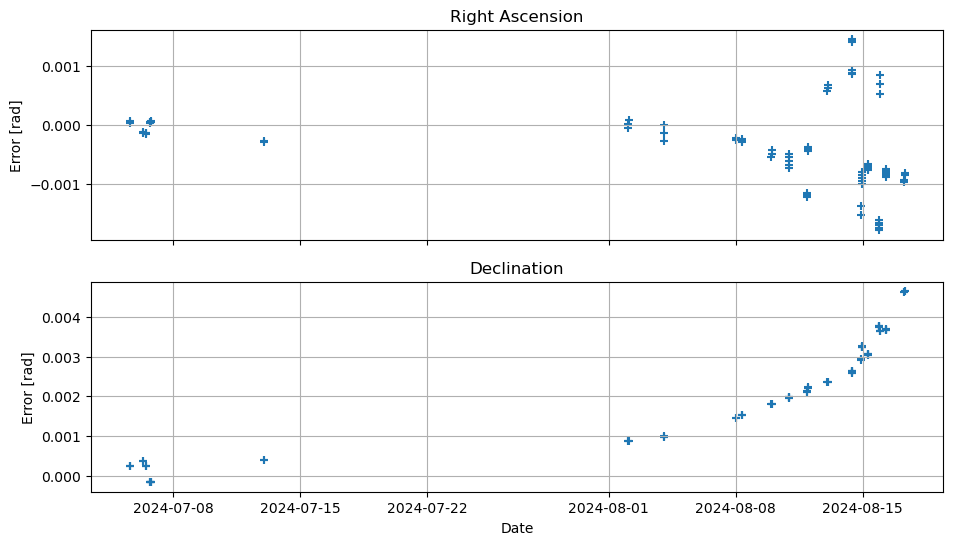

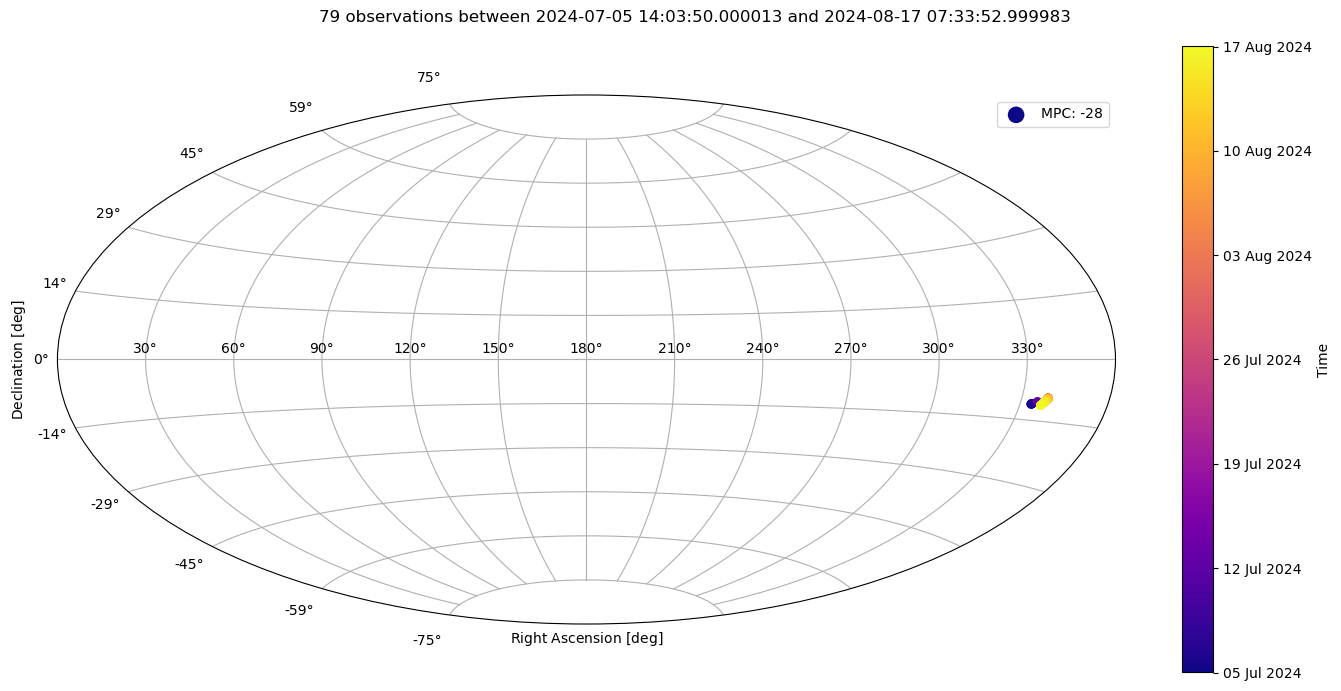

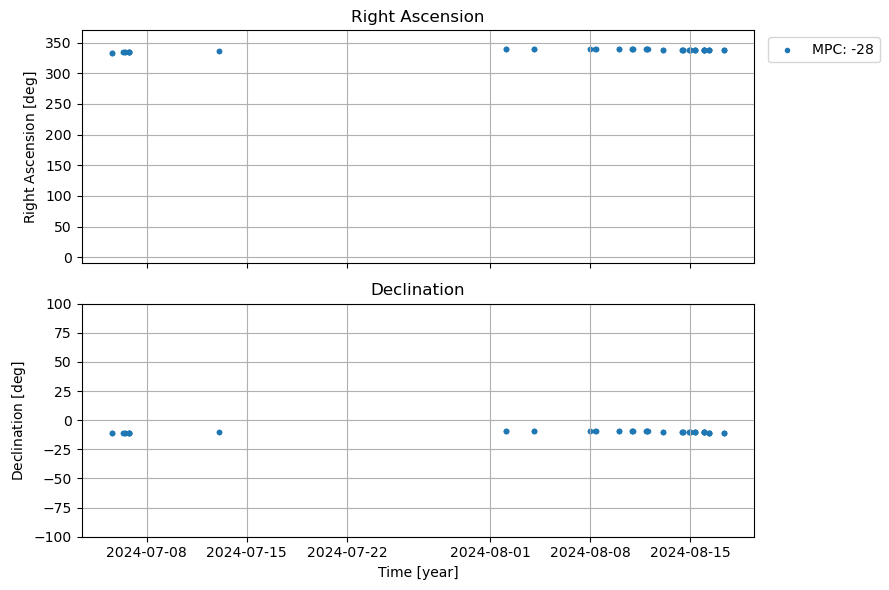

In [44]:
# create plot
fig, (ax_ra, ax_dec) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

#print(f'RA residuals:\n {jpl_RA - batch_RA}')
#print(f'DEC residuals:\n + {jpl_DEC-batch_DEC}')

ax_ra.scatter(batch_times_utc, (jpl_RA - batch_RA), marker="+")
ax_dec.scatter(batch_times_utc, (jpl_DEC - batch_DEC), marker="+")

ax_ra.set_ylabel("Error [rad]")
ax_dec.set_ylabel("Error [rad]")
ax_dec.set_xlabel("Date")

ax_ra.grid()
ax_dec.grid()

ax_ra.set_title("Right Ascension")
ax_dec.set_title("Declination")

plt.show()

### Plotting observations
"""
The `.plot_observations_sky()` method can be used to view a projection of the observations. Similarly, `.plot_observations_temporal()` shows the declination and right ascension of a batch's bodies over time.
"""

#print(f'batch_RA in radians from table.query: \n\n{batch_RA}') 
#print(f'batch_RA in degrees: \n\n{np.degrees(batch_RA)}') 
#print(f'batch_DEC in radians from table.query: \n\n{batch_DEC}') 
#print(f'batch_DEC in degrees: \n\n{np.degrees(batch_DEC)}') 

# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
fig = batch1.plot_observations_sky(projection = 'aitoff')
plt.show()

fig = batch1.plot_observations_temporal()
plt.show()

In [28]:
from tudatpy.util import result2array

# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch1.epoch_start
epoch_end_nobuffer = batch1.epoch_end

print(f'Epoch Start (no buffer): {epoch_start_nobuffer}')
print(f'Epoch End (no buffer): {epoch_end_nobuffer}')

time_buffer = 1 * 5 * 86400

#number of iterations for our estimation
number_of_pod_iterations = 7

# timestep of 300s for our estimation
timestep_global = 300

epoch_start_buffer = epoch_start_nobuffer - time_buffer 
epoch_end_buffer = epoch_end_nobuffer + time_buffer 

print(f'Epoch Start (with buffer): {epoch_start_buffer}')
print(f'Epoch End (with buffer): {epoch_end_buffer}')

Epoch Start (no buffer): 773460299.1840273
Epoch End (no buffer): 777152102.1829114
Epoch Start (with buffer): 773028299.1840273
Epoch End (with buffer): 777584102.1829114


In [29]:
# Define accelerations
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# Set up the accelerations settings for each body, in this case only JUICE
acceleration_settings = {}
for body in batch1.MPC_objects:
    acceleration_settings[str(body)] = accelerations

acceleration_settings
# create the acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)


#benchmark state for later comparison retrieved from SPICE
initial_states = spice.get_body_cartesian_state_at_epoch(
    'JUICE',
    global_frame_origin,
    global_frame_orientation,
    "NONE",
    epoch_start_buffer,
)

print(initial_states)

[ 7.47471113e+10 -1.60493388e+11 -6.87836554e+10  1.89554211e+04
  1.22906728e+04  5.22045432e+03]


In [30]:
target_spkid = '-28'

#benchmark state for later comparison retrieved from SPICE
#initial_states = spice.get_body_cartesian_state_at_epoch(
#    'JUICE',
#    global_frame_origin,
#    global_frame_orientation,
#    "NONE",
#    epoch_start_buffer,
#)

print(initial_states)
# benchmark state for later comparison retrieved from SPICE
#initial_states = spice.get_body_cartesian_state_at_epoch(
#    'JUICE',
#    global_frame_origin,
#    global_frame_orientation,
#    "NONE",
#    epoch_start_buffer,
#)

spice_state_list = []
epochs_spice = np.arange(epoch_start_buffer, epoch_end_buffer, 100)

for epoch in epochs_spice:
    spice_state = spice.get_body_cartesian_state_at_epoch(
        'JUICE',
        global_frame_origin,
        global_frame_orientation,
        "NONE",
        epoch,
    )
    spice_state_list.append(list(spice_state))

# Add random offset for initial guess
np.random.seed = 1

initial_position_offset = 1e5*1000
initial_velocity_offset = 100

initial_guess = initial_states.copy()
initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_states)

[ 7.47471113e+10 -1.60493388e+11 -6.87836554e+10  1.89554211e+04
  1.22906728e+04  5.22045432e+03]
Error between the real initial state and our initial guess:
[ 3.25797108e+07 -6.45374557e+07  5.25108479e+07 -4.62698604e+01
 -8.50562840e+01 -7.37226050e+01]


In [31]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    epoch_start_buffer,
    timestep_global,
    propagation_setup.integrator.rkf_78,
    timestep_global,
    timestep_global,
    1.0,
    1.0,
)

x_spice = [state[0] for state in spice_state_list]
y_spice = [state[1] for state in spice_state_list]
z_spice = [state[2] for state in spice_state_list]

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=central_bodies,
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

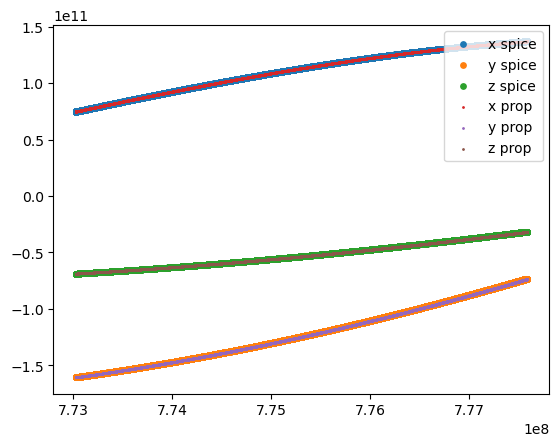

Error between the real spice final state and our final state:
[-1.07442296e+08 -4.65795400e+08 -2.93311671e+08 -2.06731191e+00
 -8.79020097e+01 -7.32762758e+01]


In [32]:
# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings
)

# Extract the resulting state history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)

time_prop = [state[0] for state in states_array]
x_prop = [state[1] for state in states_array]
y_prop = [state[2] for state in states_array]
z_prop = [state[3] for state in states_array]


plt.scatter(epochs_spice, x_spice, s = 15, label = 'x spice')
plt.scatter(epochs_spice, y_spice, s = 15, label = 'y spice')
plt.scatter(epochs_spice, z_spice, s = 15, label = 'z spice')
plt.scatter(time_prop, x_prop, s = 1, label = 'x prop')
plt.scatter(time_prop, y_prop, s = 1, label = 'y prop')
plt.scatter(time_prop, z_prop, s = 1, label = 'z prop')


plt.legend()
plt.show()

states_array[:]
print("Error between the real spice final state and our final state:")
print(states_array[-1][1:] - spice_state_list[-1][:])

In [33]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

In [34]:
# Set up the estimator
estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True,
)

# provide the observation collection as input, and limit number of iterations for estimation.
pod_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=number_of_pod_iterations,
    ),
)

# Set methodological options
pod_input.define_estimation_settings(reintegrate_variational_equations=True)

In [35]:
# Perform the estimation
pod_output = estimator.perform_estimation(pod_input)

Calculating residuals and partials 158
Current residual: 6.2008
Parameter update 5.67336e+12 -2.01462e+12 -5.76589e+11      -791545       635825       229611
Calculating residuals and partials 158
Current residual: 5.64436
Parameter update-3.45751e+16  1.22877e+16  3.55061e+15   4.7584e+09  -3.8457e+09 -1.39421e+09
Calculating residuals and partials 158


Warning, detected jump in observation residual of size 5.99148 for observable type 1
Warning, detected jump in observation residual of size 5.99138 for observable type 1
Warning, detected jump in observation residual of size 5.99141 for observable type 1
Warning, detected jump in observation residual of size 5.99121 for observable type 1
Warning, detected jump in observation residual of size 5.99128 for observable type 1
Warning, detected jump in observation residual of size 5.99118 for observable type 1
Warning, detected jump in observation residual of size 5.99122 for observable type 1
Warning, detected jump in observation residual of size 5.99397 for observable type 1
Warning when performing least squares, condition number is 1.39904e+09


RuntimeError: Error in interpolator, requesting data point outside of boundaries, requested data at 713592615.23344719 but limit values are 773028299.18402731 and 777584399.18402731